# DEMAND FORECASTING FOR SKU2

* Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox

* Data Loading

In [2]:
import pandas as pd
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU2')
df = df.set_index('Date of Invoice').sort_index()

* Checking for missing dates

In [3]:
 # Create a full list of all dates from the first to the last date in your dataset, with daily frequency
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Find the dates that are in 'full_range' but NOT in your actual DataFrame index
missing_dates = full_range.difference(df.index)

# Print how many dates are missing in total
print(f"Missing Dates: {len(missing_dates)} found.")


# If there are missing dates, show the first 10 missing ones as a preview
if len(missing_dates) > 0:
    print(missing_dates[:10])
    
#  Check the difference between consecutive dates
date_diff_counts = df.index.to_series().diff().dropna().value_counts()

#  Print how often each type of date gap occurs (e.g., 1 day, 2 days, etc.)
print("\nDate Differences:")
print(date_diff_counts)

# Check if there's more than one type of date gap, or if it's not exactly 1 day
if len(date_diff_counts) > 1 or date_diff_counts.index[0] != pd.Timedelta(days=1):
    print("Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.")
else:
    print("Data is uniformly spaced by 1 day. Use `method='linear'` for interpolation.")

Missing Dates: 322 found.
DatetimeIndex(['2022-04-16', '2022-04-17', '2022-04-18', '2022-04-19',
               '2022-04-23', '2022-04-24', '2022-04-25', '2022-04-26',
               '2022-04-27', '2022-04-29'],
              dtype='datetime64[ns]', freq=None)

Date Differences:
Date of Invoice
1 days     92
2 days     44
4 days     25
3 days     24
5 days      8
7 days      7
6 days      5
8 days      3
9 days      3
12 days     1
Name: count, dtype: int64
Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.


* Check for outliers in QTY using IQR


Outliers in QTY: 10 found.
Consider using median or rolling median to smooth outlier values in QTY.


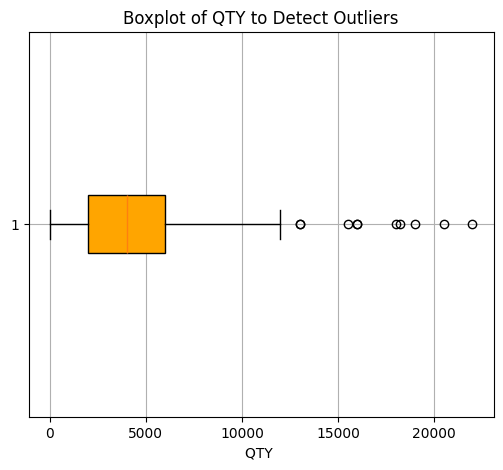

In [4]:
import matplotlib.pyplot as plt

# Your existing outlier detection
Q1 = df['QTY '].quantile(0.25)
Q3 = df['QTY '].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['QTY '] < Q1 - 1.5 * IQR) | (df['QTY '] > Q3 + 1.5 * IQR)]

print(f"\nOutliers in QTY: {len(outliers)} found.")
if len(outliers) > 0:
    print("Consider using median or rolling median to smooth outlier values in QTY.")
else:
    print("QTY data looks clean. You can use interpolation safely.")

# Plotting boxplot
plt.figure(figsize=(6, 5))
plt.boxplot(df['QTY '], vert=False, patch_artist=True, boxprops=dict(facecolor='orange', color='black'),)
plt.title('Boxplot of QTY to Detect Outliers')
plt.xlabel('QTY ')
plt.grid(True)
plt.show()

* Reindex and show what missing rows look like

In [5]:
df_reindexed = df.reindex(full_range)
print("\nReindexed Data Preview (with NaNs):")
print(df_reindexed.head(10))


Reindexed Data Preview (with NaNs):
            Material No. Cat-III Desc           Cat-IV Desc    QTY   NET SALES
2022-04-14    61004149.0      2W BULB  2W INCANDENSCENT BUL  2500.0    16268.0
2022-04-15    61004149.0      2W BULB  2W INCANDENSCENT BUL  5000.0    31801.0
2022-04-16           NaN          NaN                   NaN     NaN        NaN
2022-04-17           NaN          NaN                   NaN     NaN        NaN
2022-04-18           NaN          NaN                   NaN     NaN        NaN
2022-04-19           NaN          NaN                   NaN     NaN        NaN
2022-04-20    61004149.0      2W BULB  2W INCANDENSCENT BUL  3000.0    21285.6
2022-04-21    61004149.0      2W BULB  2W INCANDENSCENT BUL  1000.0     6977.6
2022-04-22    61004149.0      2W BULB  2W INCANDENSCENT BUL  1500.0    10642.8
2022-04-23           NaN          NaN                   NaN     NaN        NaN


* Cleaning

In [6]:
# === Load the SKU2 sheet ===
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU2')

# === Clean column names ===
df.columns = df.columns.str.strip()

# === Convert date column to datetime ===
df['Date of Invoice'] = pd.to_datetime(df['Date of Invoice'])

# === Set index to date ===
df.set_index('Date of Invoice', inplace=True)

# === Reindex to fill missing days ===
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_full = df.reindex(full_index)
df_full.index.name = 'Date of Invoice'


# === Apply rolling median first (smooth outliers) ===
df_full['QTY_rolled'] = df_full['QTY'].rolling(window=7, center=True, min_periods=1).median()

# === Interpolate missing values after smoothing ===
df_full['QTY_rolled'] = df_full['QTY_rolled'].interpolate(method='time').round().astype('Int64')

# === Forward-fill static info (Material No.) ===
df_full['Material No.'] = df_full['Material No.'].ffill().astype('Int64')

# === Reset index for resampling ===
df_full = df_full.reset_index()

# === Drop unneeded columns if present ===
df_cleaned = df_full.drop(columns=['Cat-III Desc', 'Cat-IV Desc', 'NET SALES'], errors='ignore')

# === Resample to weekly demand (week ending on Monday) ===
df_weekly = df_cleaned.resample('W-Mon', on='Date of Invoice').sum(numeric_only=True)['QTY_rolled'].reset_index()

# === Preview cleaned weekly data ===
print(df_weekly.head())

  Date of Invoice  QTY_rolled
0      2022-04-18       17250
1      2022-04-25       11500
2      2022-05-02       21000
3      2022-05-09       26250
4      2022-05-16       43500


* Plotting Weekly Demand

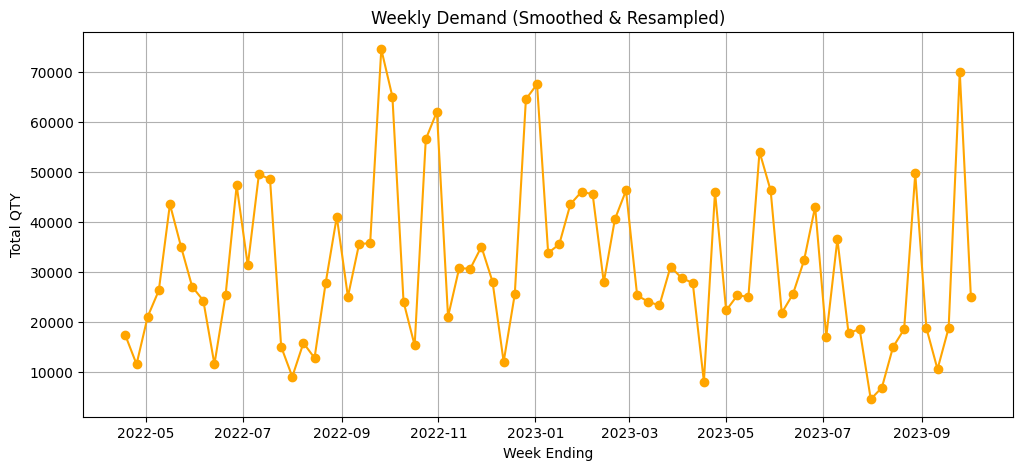

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# === Plot weekly demand ===
plt.figure(figsize=(12, 5))
plt.plot(df_weekly['Date of Invoice'], df_weekly['QTY_rolled'], marker='o',color='orange')
plt.title('Weekly Demand (Smoothed & Resampled)')
plt.xlabel('Week Ending')
plt.ylabel('Total QTY')
plt.grid(True)
plt.show()

 Based on the observed pattern in the smoothed weekly demand plot,where the magnitude of fluctuations increases with the level of demand.
 
 Multiplicative Decomposition is recommended to accurately model trend and seasonality.

* Plotting graph of BoxCox & Log Transformation

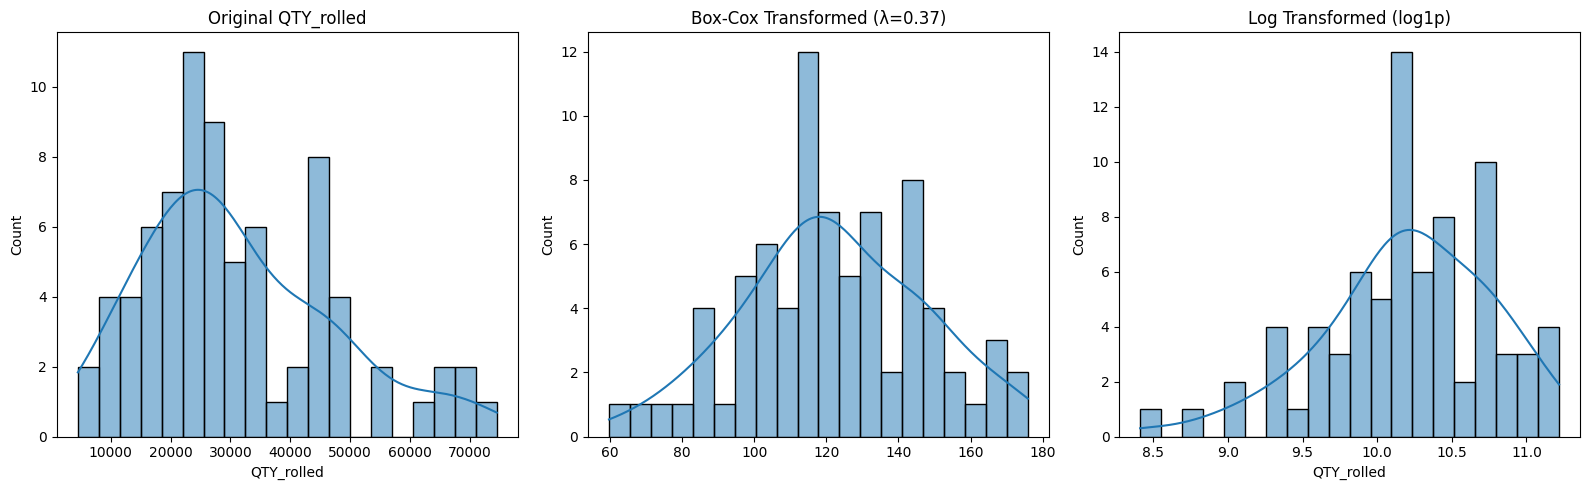

In [8]:
# Drop NaNs and non-positive values
qty = df_weekly['QTY_rolled'].dropna()
qty = qty[qty > 0]

# Box-Cox transformation
qty_boxcox, lmbda = boxcox(qty)
# Store the transformed series in your DataFrame
df_weekly['QTY_boxcox'] = qty_boxcox

# Log transformation (optional)
qty_log = np.log1p(qty)  # log1p handles zero values safely
df_weekly['QTY_log'] = qty_log

# Plotting
plt.figure(figsize=(16, 5))

# Original
plt.subplot(1, 3, 1)
sns.histplot(qty, kde=True, bins=20)
plt.title("Original QTY_rolled")

# Box-Cox
plt.subplot(1, 3, 2)
sns.histplot(qty_boxcox, kde=True, bins=20)
plt.title(f"Box-Cox Transformed (λ={lmbda:.2f})")

# Log Transformed
plt.subplot(1, 3, 3)
sns.histplot(qty_log, kde=True, bins=20)
plt.title("Log Transformed (log1p)")

plt.tight_layout()
plt.show()

* Seasonal Decomposition

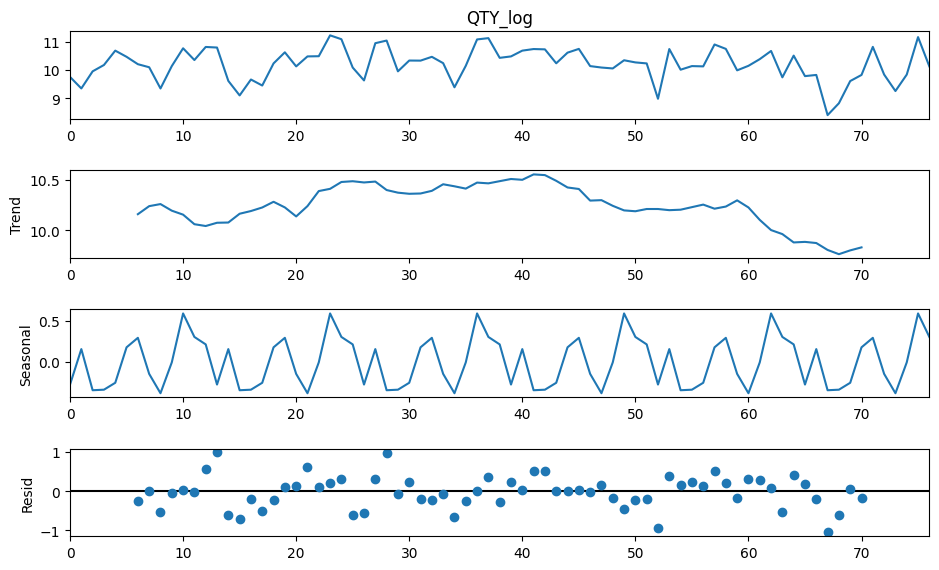

In [9]:
result = seasonal_decompose(df_weekly['QTY_log'], model='additive', period=13)  
fig = result.plot()
fig.set_size_inches(10, 6)
plt.show()

* STL Decomposition

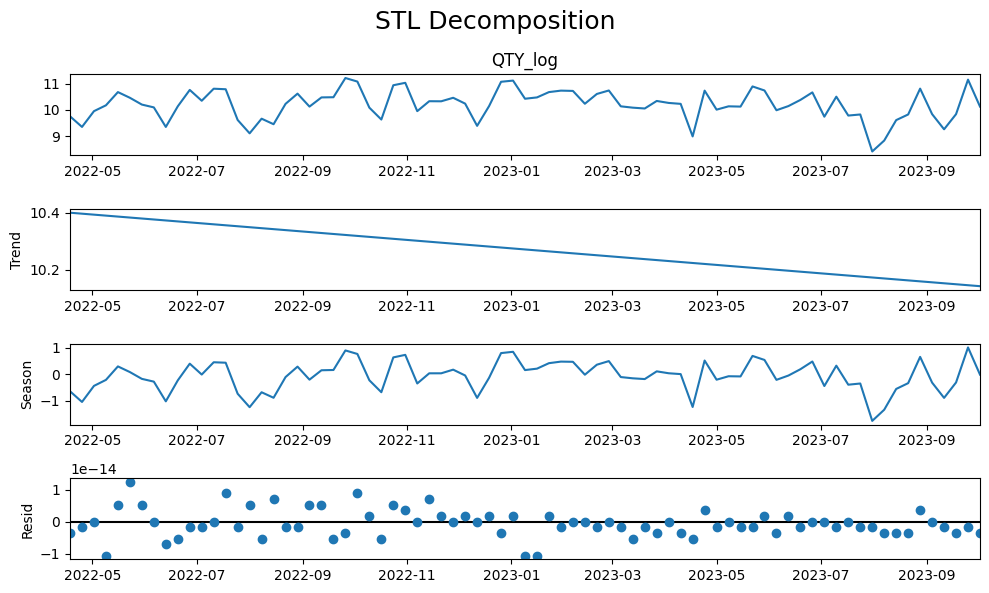

In [10]:
#STL Decomposition
from statsmodels.tsa.seasonal import STL
df_weekly.set_index('Date of Invoice', inplace=True)

# STL expects a datetime index with frequency
df_weekly.index = pd.to_datetime(df_weekly.index)
df_weekly = df_weekly.asfreq('W-MON')

# STL Decomposition (seasonal_period=53 closer to 52 for weekly data)
stl = STL(df_weekly['QTY_log'], seasonal=53)
result = stl.fit()

# Plot the components
fig = result.plot()
fig.set_size_inches(10, 6)
plt.suptitle("STL Decomposition", fontsize=18)
plt.tight_layout()
plt.show()

* ADF Test for Checking Stationarity


ADF Test for Differencing Level: 0
ADF Statistic: -1.4420635751100954
p-value: 0.5619525763038824
Critical Value (1%): -3.53692771987915
Critical Value (5%): -2.907887369384766
Critical Value (10%): -2.591493291015625
The series is non-stationary, applying differencing...

ADF Test for Differencing Level: 1
ADF Statistic: -4.641883548177257
p-value: 0.0001080560533157249
Critical Value (1%): -3.5386953618719676
Critical Value (5%): -2.9086446751210775
Critical Value (10%): -2.591896782564878

The series is stationary (reject null hypothesis)

Total differencing applied: 1


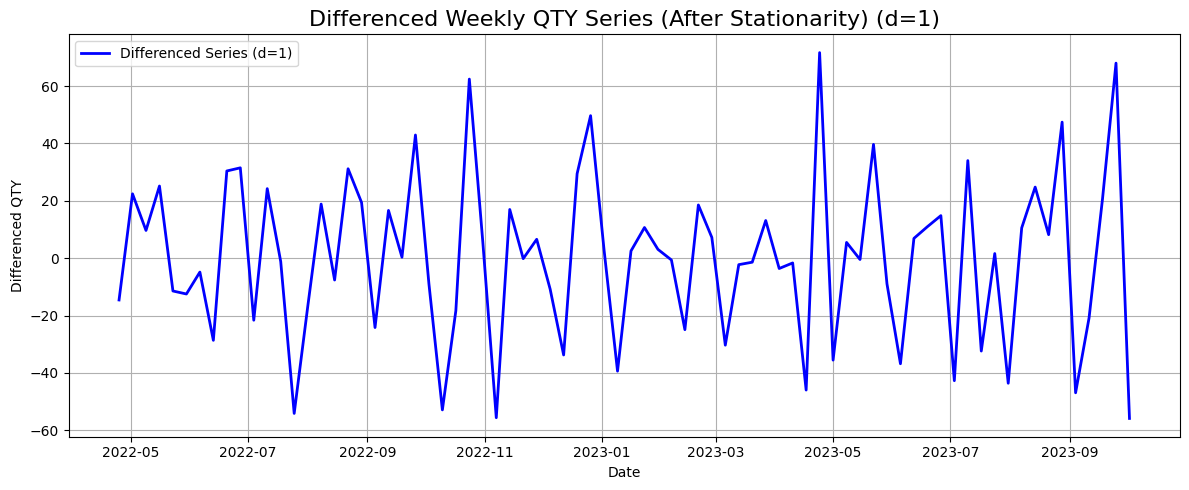

In [11]:
diff_series = df_weekly['QTY_boxcox'].copy()
d = 0  # Differencing counter

while True:
    print(f"\nADF Test for Differencing Level: {d}")
    result = adfuller(diff_series.dropna())

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")

    if result[1] < 0.05:
        print("\nThe series is stationary (reject null hypothesis)")
        break
    else:
        print("The series is non-stationary, applying differencing...")
        diff_series = diff_series.diff().dropna()
        d += 1

print(f"\nTotal differencing applied: {d}")

# Plotting the differenced series
plt.figure(figsize=(12, 5))
plt.plot(diff_series, color='blue', linewidth=2, label=f'Differenced Series (d={d})')
plt.title(f'Differenced Weekly QTY Series (After Stationarity) (d={d})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Differenced QTY')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* ACF & PACF Plots

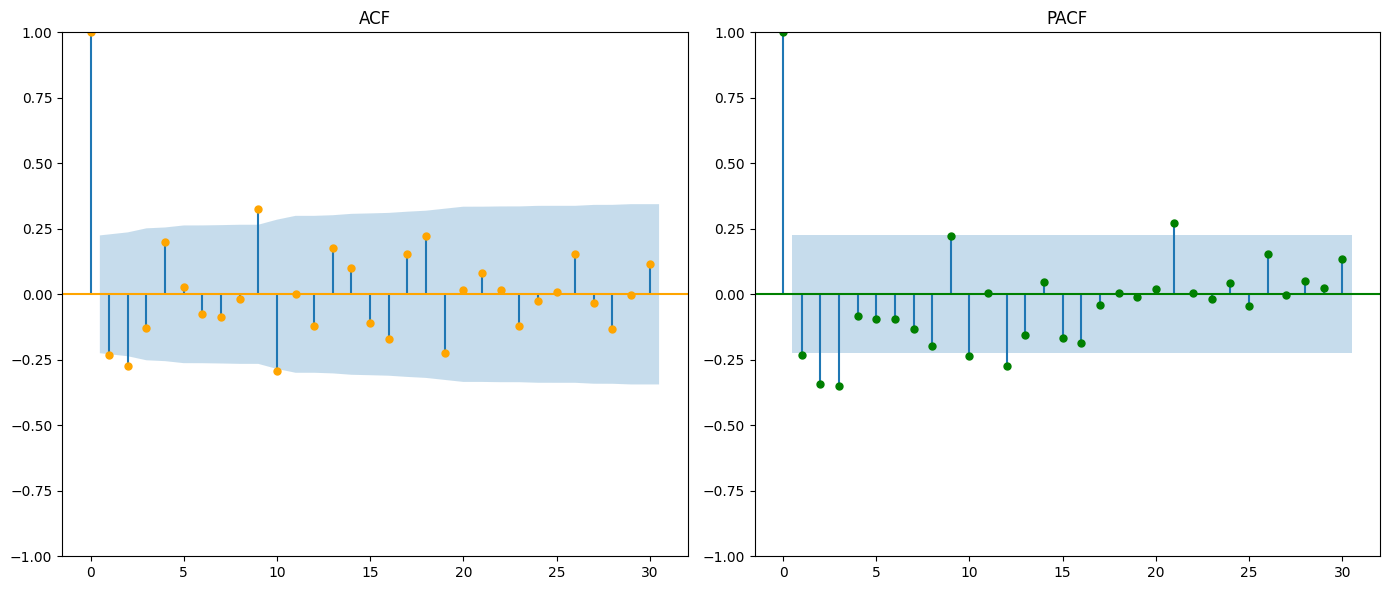

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=30, ax=plt.gca(),color='orange')
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=30, ax=plt.gca(), method='ywm',color='green')
plt.title('PACF')

plt.tight_layout()
plt.show()

* Ljung-Box Test (Statistical Test for White Noise)

In [13]:
# Apply Ljung-Box test on the differenced series
ljung_box_result = acorr_ljungbox(diff_series.dropna(), lags=[10], return_df=True)

print("Ljung-Box Test Result:")
print(ljung_box_result)

# Interpretation
p_value = ljung_box_result['lb_pvalue'].values[0]

if p_value > 0.05:
    print("\nThe series appears to be white noise (p-value > 0.05).")
    print("→ It has no predictable structure. Forecasting may not be meaningful.")
else:
    print("\nThe series is NOT white noise (p-value <= 0.05).")
    print("→ It has autocorrelation and structure that can be modeled.")

Ljung-Box Test Result:
      lb_stat  lb_pvalue
10  32.860728   0.000287

The series is NOT white noise (p-value <= 0.05).
→ It has autocorrelation and structure that can be modeled.


* Train-Test Split, Log Transformation, and Model Evaluation Setup

In [14]:
from statsmodels.tsa.seasonal import STL
warnings.filterwarnings("ignore")

train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_rolled']
y_test = test['QTY_rolled']

# Handle zero or negative values in the data before log transformation
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

# Replace zero or negative values with small positive values
y_train_clean[y_train_clean <= 0] = 1e-6
y_test_clean[y_test_clean <= 0] = 1e-6

# Log-transform train and test series
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test_clean)

#  ADD STL DECOMPOSITION
stl = STL(y_train_log, period=52, robust=True)   # 52 weeks = annual seasonality
res = stl.fit()

best_method = None
best_mape = float('inf')
results = {}
forecast_4weeks = {}
test_forecasts = {}

Naive - MAPE: 62.31%
Moving Average - MAPE: 32.69%
SES - MAPE: 35.40%
Holt Linear - MAPE: 32.88%
Holt-Winters - MAPE: 22.35%
ARIMA - MAPE: 23.24%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=132.050, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=555.925, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=130.228, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=136.848, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=121.984, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=120.133, Time=0.0

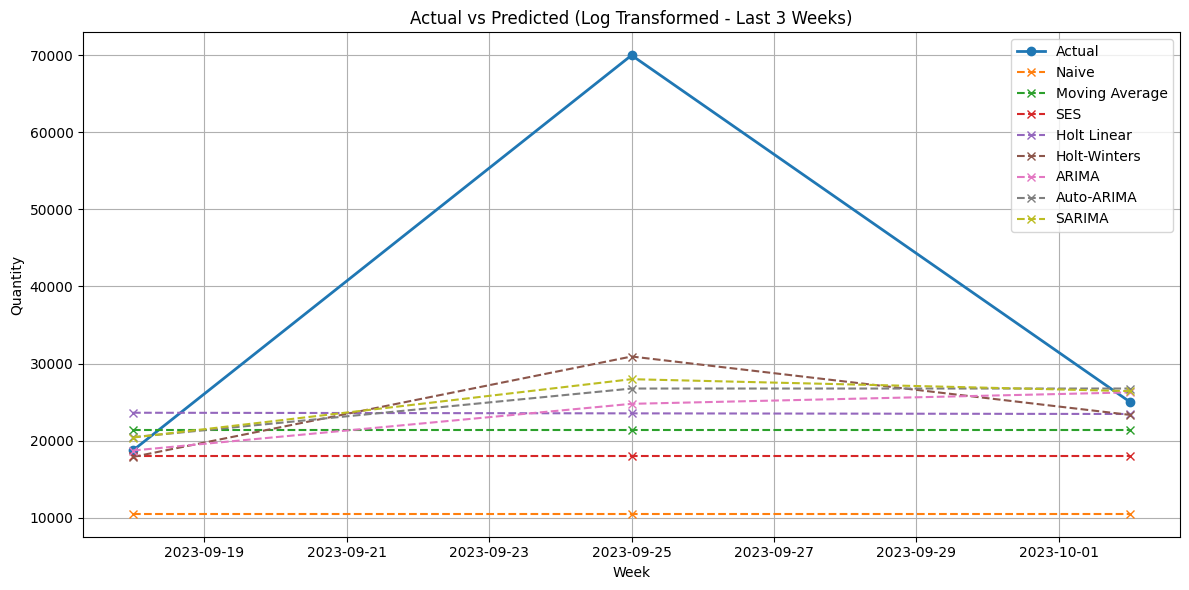

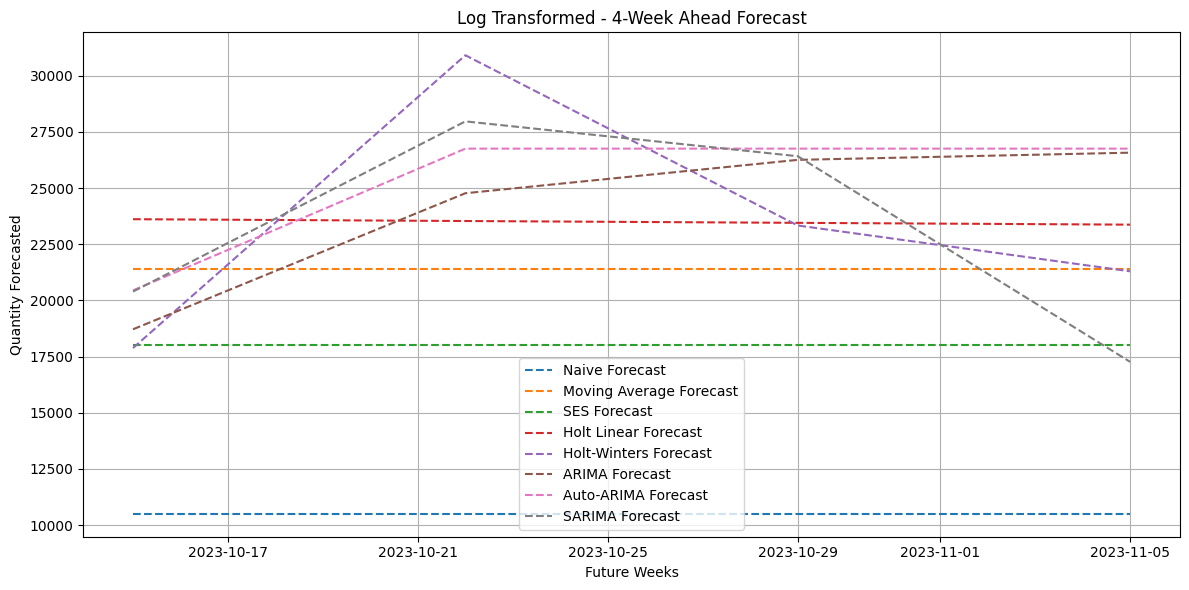


4-Week Forecast by Best Model (Holt-Winters):
2023-09-18    17879
2023-09-25    30910
2023-10-02    23333
2023-10-09    21293
Freq: W-MON, dtype: int32


In [15]:
def evaluate_model(name, forecast_test_log, forecast_future_log):
    global best_method, best_mape
    try:
        # Inverse transformation
        forecast_test = np.round(np.expm1(forecast_test_log)).astype(int)
        forecast_future = np.round(np.expm1(forecast_future_log)).astype(int)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_test, forecast_test)
        results[name] = mape
        test_forecasts[name] = forecast_test
        forecast_4weeks[name] = forecast_future

        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

# Models

# Naive model
try:
    naive_test = [y_train_log.iloc[-1]] * 3
    naive_future = [y_train_log.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# Moving Average model
try:
    ma_test = [y_train_log[-3:].mean()] * 3
    ma_future = [y_train_log[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# Simple Exponential Smoothing (SES)
try:
    ses_model = SimpleExpSmoothing(y_train_log).fit()
    ses_test = ses_model.forecast(3)
    ses_future = ses_model.forecast(4)
    evaluate_model("SES", ses_test, ses_future)
except Exception as e:
    print("SES - Error:", e)

# Holt Linear
try:
    holt_model = Holt(y_train_log).fit()
    holt_test = holt_model.forecast(3)
    holt_future = holt_model.forecast(4)
    evaluate_model("Holt Linear", holt_test, holt_future)
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters
try:
    hw_model = ExponentialSmoothing(y_train_log, seasonal='mul', seasonal_periods=13).fit()
    hw_test = hw_model.forecast(3)
    hw_future = hw_model.forecast(4)
    evaluate_model("Holt-Winters", hw_test, hw_future)
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train_log, order=(1,0,1)).fit()
    arima_test = arima_model.forecast(3)
    arima_future = arima_model.forecast(4)
    evaluate_model("ARIMA", arima_test, arima_future)
except Exception as e:
    print("ARIMA - Error:", e)

# Auto-ARIMA
try:
    auto_model = auto_arima(y_train_log, seasonal=False, stepwise=True, trace=True)
    auto_test = auto_model.predict(n_periods=3)
    auto_future = auto_model.predict(n_periods=4)
    evaluate_model("Auto-ARIMA", auto_test, auto_future)
except Exception as e:
    print("Auto-ARIMA - Error:", e)

# SARIMA
try:
    sarima_model = SARIMAX(y_train_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52)).fit()
    sarima_test = sarima_model.forecast(3)
    sarima_future = sarima_model.forecast(4)
    evaluate_model("SARIMA", sarima_test, sarima_future)
except Exception as e:
    print("SARIMA - Error:", e)

# Output best method
if best_mape < 0.10:
    print(f"\n Best method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\n No method achieved MAPE < 10%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual", marker='o', linewidth=2)
for name, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=f"{name}", linestyle='--', marker='x')
plt.title("Actual vs Predicted (Log Transformed - Last 3 Weeks)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot next 4-week forecasts
plt.figure(figsize=(12, 6))
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
for name, forecast in forecast_4weeks.items():
    plt.plot(future_index, forecast, label=f"{name} Forecast", linestyle='--')
plt.title("Log Transformed - 4-Week Ahead Forecast")
plt.xlabel("Future Weeks")
plt.ylabel("Quantity Forecasted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the best 4-week forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")

* Model Training, Evaluation (MAPE Based), and Future Forecasting with Inverse Box-Cox Transformation

In [16]:
train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_boxcox']
y_test = test['QTY_boxcox']
best_method = None
best_mape = float('inf')

test_forecasts = {}
forecast_4weeks = {}

# Store fitted lambda used for boxcox
fitted_lambda = lmbda 

def evaluate_model(name, forecast_test, forecast_future):
    global best_method, best_mape
    try:
        mape = mean_absolute_percentage_error(y_test, forecast_test)
        results[name] = mape
        test_forecasts[name] = forecast_test
        forecast_4weeks[name] = forecast_future
        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

In [17]:
# Naive Forecast
try:
    naive_test = [y_train.iloc[-1]] * 3
    naive_future = [y_train.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# 2. Moving Average
try:
    ma_test = [y_train[-3:].mean()] * 3
    ma_future = [y_train[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# Simple Exponential Smoothing
try:
    ses_model = SimpleExpSmoothing(y_train).fit()
    ses_forecast = ses_model.forecast(3)
    ses_future = ses_model.forecast(4)
    evaluate_model("SES", ses_forecast, ses_future)
except Exception as e:
    print("SES - Error:", e)

# Holt’s Linear Trend
try:
    holt_model = Holt(y_train).fit()
    holt_forecast = holt_model.forecast(3)
    holt_future = holt_model.forecast(4)
    evaluate_model("Holt Linear", holt_forecast,holt_future)
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters Seasonal
try:
    hw_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=13).fit()
    hw_forecast = hw_model.forecast(3)
    hw_future = hw_model.forecast(4)
    evaluate_model("Holt-Winters", hw_forecast, hw_future)
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train, order=(2,0,1)).fit()
    arima_forecast = arima_model.forecast(3)
    arima_future = arima_model.forecast(4)
    evaluate_model("ARIMA", arima_forecast, arima_future)
except Exception as e:
    print("ARIMA - Error:", e)

# Auto Arima
try:
    auto_model = auto_arima(y_train, seasonal=False, stepwise=True, trace=True)
    auto_test = auto_model.predict(n_periods=3)
    auto_future = auto_model.predict(n_periods=4)
    evaluate_model("Auto-ARIMA", auto_test, auto_future)
except Exception as e:
    print("ARIMA - Error:", e)   


# SARIMA
try:
    sarima_model = SARIMAX(y_train, order=(2,0,1), seasonal_order=(2,0,1,52)).fit()
    sarima_forecast = sarima_model.forecast(3)
    sarima_future = sarima_model.forecast(4)
    evaluate_model("SARIMA", sarima_forecast, sarima_future)
except Exception as e:
    print("SARIMA - Error:", e)

# Output best
if best_mape < 0.10:
    print(f"\nBest method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\nNo method achieved MAPE < 10%")

Naive - MAPE: 33.35%
Moving Average - MAPE: 15.29%
SES - MAPE: 16.34%
Holt Linear - MAPE: 15.01%
Holt-Winters - MAPE: 8.79%
ARIMA - MAPE: 13.23%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=689.835, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=925.788, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=706.825, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=847.178, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=687.855, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=800.458, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=694.725, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=689.816, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=689.548, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=691.468, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=682.831, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   

In [18]:
# 🔄 Inverse Box-Cox Transformations to bring data back to original scale
 
for model in test_forecasts:
    try:
        test_forecasts[model] = np.round(inv_boxcox(test_forecasts[model], fitted_lambda)).astype(int)
    except Exception as e:
        print(f"Error inverting BoxCox for test: {model} - {e}")

for model in forecast_4weeks:
    try:
        forecast_4weeks[model] = np.round(inv_boxcox(forecast_4weeks[model], fitted_lambda)).astype(int)
    except Exception as e:
        print(f"Error inverting BoxCox for forecast: {model} - {e}")

# Inverse test actuals
actual_test = inv_boxcox(y_test, fitted_lambda)
actual_train = inv_boxcox(y_train, fitted_lambda)

# ✅ Now all forecasts and actuals are back to the original QTY scale for correct evaluation and visualization

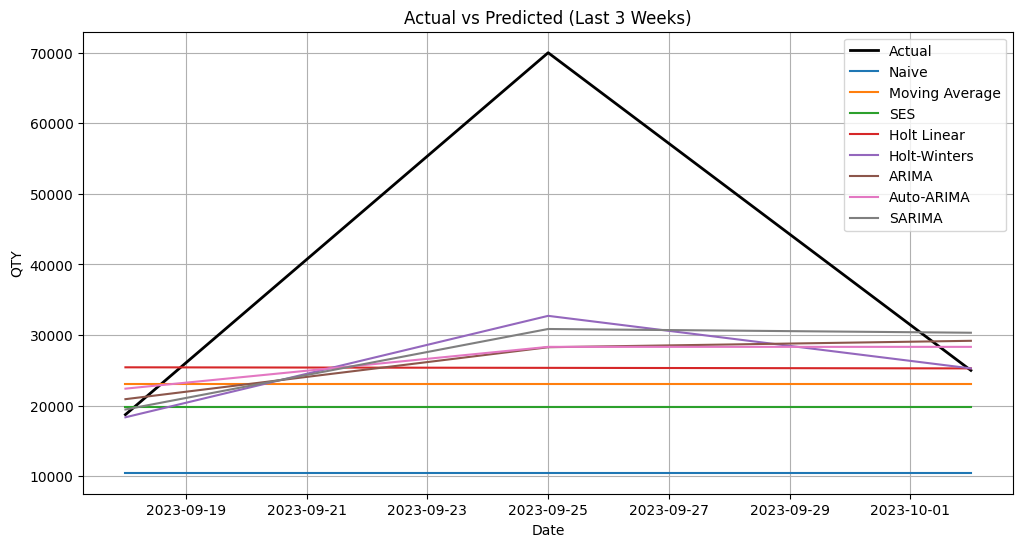

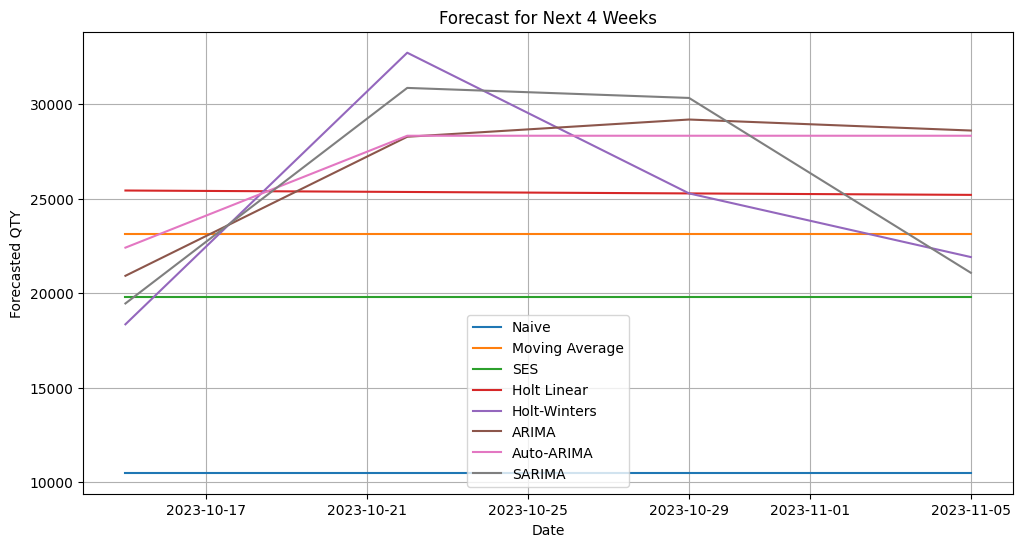

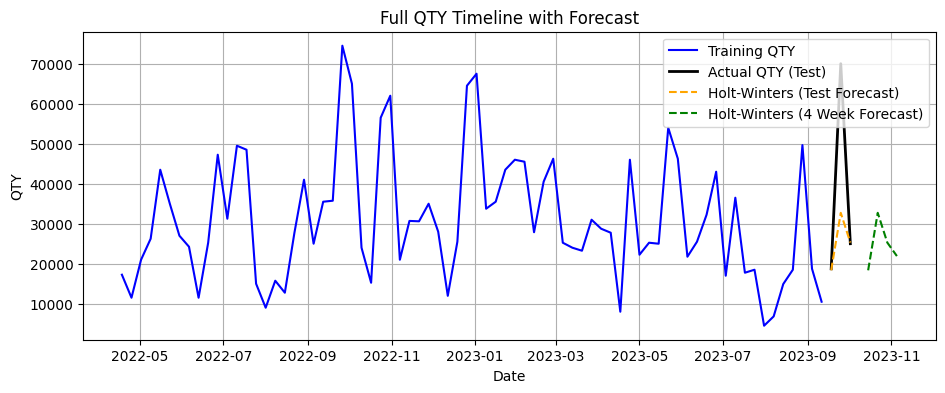


4-Week Forecast by Best Model (Holt-Winters):
2023-09-18    18353
2023-09-25    32724
2023-10-02    25280
2023-10-09    21911
Freq: W-MON, dtype: int32


In [19]:
# 1️⃣ PLOT: Actual vs Predicted for Last 3 Weeks
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, actual_test, label='Actual', color='black', linewidth=2)
for model, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=model)
plt.title("Actual vs Predicted (Last 3 Weeks)")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ PLOT: Forecast for Next 4 Weeks (Original Scale)
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
plt.figure(figsize=(12, 6))
for model, forecast in forecast_4weeks.items():
    plt.plot(future_dates, forecast, label=model)
plt.title("Forecast for Next 4 Weeks")
plt.xlabel("Date")
plt.ylabel("Forecasted QTY")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ PLOT: Complete Timeline (Train + Test + Forecast)
plt.figure(figsize=(11, 4))
plt.plot(y_train.index, actual_train, label='Training QTY', color='blue')
plt.plot(y_test.index, actual_test, label='Actual QTY (Test)', color='black', linewidth=2)
if best_method in test_forecasts:
    plt.plot(y_test.index, test_forecasts[best_method], '--', label=f'{best_method} (Test Forecast)', color='orange')
if best_method in forecast_4weeks:
    plt.plot(future_dates, forecast_4weeks[best_method], '--', label=f'{best_method} (4 Week Forecast)', color='green')
plt.title("Full QTY Timeline with Forecast")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()

# Print only best forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")
